In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
from python_files.utils import *
from python_files.cnn import *
from python_files.LSTM import *

ModuleNotFoundError: No module named 'python_files'

In [4]:
acchulu = ['అ', 'ఆ', 'ఇ', 'ఈ', 'ఉ', 'ఊ', 'ఋ', 'ౠ', 'ఌ', 'ౡ', 'ఎ', 'ఏ', 'ఐ', 'ఒ', 'ఓ', 'ఔ', 'అం', 'అః']
hallulu = ['క', 'ఖ', 'గ', 'ఘ', 'ఙ',
           'చ', 'ఛ', 'జ', 'ఝ', 'ఞ',
           'ట', 'ఠ', 'డ', 'ఢ', 'ణ',
           'త', 'థ', 'ద', 'ధ', 'న',
           'ప', 'ఫ', 'బ', 'భ', 'మ',
           'య', 'ర', 'ల', 'వ', 'శ', 'ష', 'స', 'హ', 'ళ', 'క్ష', 'ఱ', 'ఴ', 'ౘ', 'ౙ','ౚ']
vallulu = ['ా', 'ి', 'ీ', 'ు' , 'ూ', 'ృ', 'ౄ', 'ె', 'ే', 'ై', 'ొ', 'ో', 'ౌ', 'ం', 'ః', 'ఁ', 'ఀ', 'ఄ', 'ౕ', 'ౖ', 'ౢ' ]
connector = ['్']
numbers = ['౦', '౧', '౨', '౩', '౪', '౫', '౬', '౭', '౮', '౯']
splcharacters= [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')',
              '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[',
              '\\', ']', '^', '_', '`', '{', '|', '}', '~', '1','2', '3', '4', '5', '6', '7', '8', '9', '0', 'ఽ']
spl = splcharacters + numbers

bases = acchulu + hallulu + spl
vms = vallulu
cms = hallulu

characters = bases+vms+cms+connector

base_mapping = {}
i = 2
for x in bases:
  base_mapping[x] = i
  i+=1

vm_mapping = {}
i = 2
for x in vms:
  vm_mapping[x] = i
  i+=1

cm_mapping = {}
i = 2
for x in cms:
  cm_mapping[x] = i
  i+=1

  
# creates a list of ductionaries with each dictionary reporesenting a term
def wordsDicts(s):
  List = []
  for i in range(len(s)):
    x = s[i]
    prev = ''
    if i > 0: prev = s[i-1]
    #----------------------------------is it a base term-----------------------
    if((x in acchulu or x in hallulu)  and prev != connector[0]):
      List.append({})
      List[-1]['base'] = x
    #----------------------------if it is a consonant modifier-----------------
    elif x in hallulu and prev == connector[0]:
      if(len(List) == 0):
        print(x)
      if('cm' not in List[-1]): List[-1]['cm'] = []
      List[len(List)-1]['cm'].append(x)

      #---------------------------if it is a vowel modifier--------------------
    elif x in vallulu:
      if(len(List) == 0):
        print(x)

      if('vm' not in List[-1]): List[-1]['vm'] = []
      List[len(List)-1]['vm'].append(x)

      #----------------------------it is a spl character-----------------------
    elif x in spl:
      List.append({})
      List[len(List)-1]['base'] = x
    else:
      continue
  return List

def one_hot_encoder(s):
  List = wordsDicts(s)
  onehot = []
  for i in range(len(List)):
    D = List[i]
    onehotbase=  [0 for _ in range(len(acchulu) +  len(hallulu) + len(spl))]
    onehotvm1 =  [0 for _ in range(len(vallulu))]
    onehotvm2 =  [0 for _ in range(len(vallulu))]
    onehotvm3 =  [0 for _ in range(len(vallulu))]
    onehotvm4 =  [0 for _ in range(len(vallulu))]

    onehotcm1 =  [0 for _ in range(len(hallulu))]   
    onehotcm2 =  [0 for _ in range(len(hallulu))]   
    onehotcm3 =  [0 for _ in range(len(hallulu))]   
    onehotcm4 =  [0 for _ in range(len(hallulu))]   

    onehotbase[base_mapping[D['base']]-1] = 1

    it = 1
    if('vm' in D):
      for j in D['vm']:
        if it == 1:
          onehotvm1[vm_mapping[j]-1] = 1
        elif it == 2:
          onehotvm2[vm_mapping[j]-1] = 1
        elif it == 3:
          onehotvm3[vm_mapping[j]-1] = 1
        elif it == 4:
          onehotvm4[vm_mapping[j]-1] = 1
        it += 1
    
    it = 1
    if('cm' in D):
      for j in D['cm']:
        if it == 1:
          onehotcm1[cm_mapping[j]-1] = 1
        elif it == 2:
          onehotcm2[cm_mapping[j]-1] = 1
        elif it == 3:
          onehotcm3[cm_mapping[j]-1] = 1
        elif it == 4:
          onehotcm4[cm_mapping[j]-1] = 1
        it += 1


    onehoti = [0,0] + onehotbase + [0,0] + onehotvm1 + [0,0] + onehotvm2 + [0,0] + onehotvm3 + [0,0] + onehotvm4 + [0,0] + onehotcm1 + [0,0] + onehotcm2 + [0,0] + onehotcm3 + [0,0] + onehotcm4 #size 2 + 112 + 4*(2 + 21) + 4*(2 + 40) = 374
    onehot.append(onehoti)
  encoded = torch.tensor(onehot).float().to(device)
  return encoded

def One_Hot_Decoder(List):
  x = ""
  for onehoti in List:
    # blank
    if onehoti[0] == 1:
      continue

    # base
    for i in range(2, 114):
      if onehoti[i] == 1:
        x += bases[i-2]

    for i in range(208, 248):
      if onehoti[i] == 1:
        x += connector[0]
        x += cms[i-208]
    for i in range(250, 290):
      if onehoti[i] == 1:
        x += connector[0]
        x += cms[i-250]
    for i in range(292, 332):
      if onehoti[i] == 1:
        x += connector[0]
        x += cms[i-292]
    for i in range(334, 374):
      if onehoti[i] == 1:
        x += connector[0]
        x += cms[i-334]

    for i in range(116, 137):
      if onehoti[i] == 1:
        x += vms[i-116]
    for i in range(139, 160):
      if onehoti[i] == 1:
        x += vms[i-139]
    for i in range(162, 183):
      if onehoti[i] == 1:
        x += vms[i-162]
    for i in range(185, 206):
      if onehoti[i] == 1:
        x += vms[i-185]
  return x

In [5]:
print(bases[90])

~


In [6]:
def index_encoding(s):
  List = wordsDicts(s)
  onehot = []
  for i in range(len(List)):
    D = List[i]
    onehotbase=  [1]
    onehotvm1 =  [1]
    onehotvm2 =  [1]
    onehotvm3 =  [1]
    onehotvm4 =  [1]
    onehotcm1 =  [1]
    onehotcm2 =  [1]
    onehotcm3 =  [1]
    onehotcm4 =  [1]


    onehotbase[0] = base_mapping[D['base']]

    it = 1
    if('vm' in D):
      for j in D['vm']:
        if it == 1:
          onehotvm1[0] = vm_mapping[j]
        elif it == 2:
          onehotvm2[0] = vm_mapping[j]
        elif it == 3:
          onehotvm3[0] = vm_mapping[j]
        elif it == 4:
          onehotvm4[0] = vm_mapping[j]
        it += 1
    
    it = 1
    if('cm' in D):
      for j in D['cm']:
        if it == 1:
          onehotcm1[0] = cm_mapping[j]
        elif it == 2:
          onehotcm2[0] = cm_mapping[j]
        elif it == 3:
          onehotcm3[0] = cm_mapping[j]
        elif it == 4:
          onehotcm4[0] = cm_mapping[j]
        it += 1
    onehoti = onehotbase + onehotvm1 + onehotvm2 + onehotvm3 + onehotvm4 + onehotcm1 + onehotcm2 + onehotcm3 + onehotcm4 #size 112 + 4*21 + 4*40 = 356
    onehot.append(onehoti)
  return onehot

def index_decoder(List):
  x = ""
  for onehoti in List:
    x += bases[onehoti[0]-2]

    if onehoti[5] != 1:
      x += connector[0]
      x += cms[onehoti[5]-2]
    if onehoti[6] != 1:
      x += connector[0]
      x += cms[onehoti[6]-2]
    if onehoti[7] != 1:
      x += connector[0]
      x += cms[onehoti[7]-2]
    if onehoti[8] != 1:
      x += connector[0]
      x += cms[onehoti[8]-2]

    if onehoti[1] != 1:
      x += vms[onehoti[1]-2]
    if onehoti[2] != 1:
      x += vms[onehoti[2]-2]
    if onehoti[3] != 1:
      x += vms[onehoti[3]-2]
    if onehoti[4] != 1:
      x += vms[onehoti[4]-2]
  return x

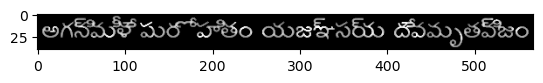

In [21]:


file_num = 1
num = 1

image = torch.load(r"C:/Users/Varun Gopal/Desktop/TeluguOCR_MLProject/KLA_Intern/Dataset/Cropped_Dataset/Images/Image10.pt").to(torch.float32).to(device)

plt.imshow(image.cpu(), cmap='gray')
plt.show()

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
print(type(image))

<class 'torch.Tensor'>


In [7]:
cnn = EncoderCNN().to(device)
rnn = LSTM_Net().to(device)

cnn_output = cnn(image.unsqueeze(1)).unsqueeze(1).to(device)
print(cnn_output.shape)

# f_output = torch.zeros(1, Text_embedding_size, image_length).to(device)

# for k in range(image_length):
#     f_output[:, :, k] = rnn(cnn_output[:, :, :, k], k == 0).to(device)

f_output = cnn_output.squeeze(1).to(device)

# f_output[:, :114, :] = F.log_softmax(f_output[:, :114, :], dim=1)

# f_output[:, 114:137, :] = F.softmax(f_output[:, 114:137, :], dim=1)
# f_output[:, 137:160, :] = F.softmax(f_output[:, 137:160, :], dim=1)
# f_output[:, 160:183, :] = F.softmax(f_output[:, 160:183, :], dim=1)
# f_output[:, 183:206, :] = F.softmax(f_output[:, 183:206, :], dim=1)

# f_output[:, 206:248, :] = F.softmax(f_output[:, 206:248, :], dim=1)
# f_output[:, 248:290, :] = F.softmax(f_output[:, 248:290, :], dim=1)
# f_output[:, 290:332, :] = F.softmax(f_output[:, 290:332, :], dim=1)
# f_output[:, 332:374, :] = F.softmax(f_output[:, 332:374, :], dim=1)

f_output = f_output.squeeze(0).to(device)

f_output = f_output.permute(1, 0)

# f_output = torch.round(f_output).to(device)

print(torch.unique(f_output))

print(f_output[:114, 0])
print(torch.argmax(f_output[:114, 0]))

print(One_Hot_Decoder(f_output))

NameError: name 'EncoderCNN' is not defined

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

target = torch.tensor([5, 6, 1, 4]).unsqueeze(0)
print(target.shape)

input = torch.zeros(10, 1, 7)
input[:, :, :] = -10
input[0, 0, 5] = 10
input[1, 0, 5] = 10
input[2, 0, 6] = 10
input[3, 0, 6] = 10
input[4, 0, 1] = 10
input[5, 0, 1] = 10
input[6, 0, 4] = 10
input[7, 0, 4] = 10
input[8, 0, 0] = 10
input[9, 0, 0] = 10


print(target)
print(input)

input = F.log_softmax(input, dim=2)

print(input)

print(torch.round(torch.exp(input)))

critereon = nn.CTCLoss(blank=0, zero_infinity=True)
loss = critereon(input, target, torch.tensor([10]), torch.tensor([4]))
print(loss)

torch.Size([1, 4])
tensor([[5, 6, 1, 4]])
tensor([[[-10., -10., -10., -10., -10.,  10., -10.]],

        [[-10., -10., -10., -10., -10.,  10., -10.]],

        [[-10., -10., -10., -10., -10., -10.,  10.]],

        [[-10., -10., -10., -10., -10., -10.,  10.]],

        [[-10.,  10., -10., -10., -10., -10., -10.]],

        [[-10.,  10., -10., -10., -10., -10., -10.]],

        [[-10., -10., -10., -10.,  10., -10., -10.]],

        [[-10., -10., -10., -10.,  10., -10., -10.]],

        [[ 10., -10., -10., -10., -10., -10., -10.]],

        [[ 10., -10., -10., -10., -10., -10., -10.]]])
tensor([[[-20., -20., -20., -20., -20.,   0., -20.]],

        [[-20., -20., -20., -20., -20.,   0., -20.]],

        [[-20., -20., -20., -20., -20., -20.,   0.]],

        [[-20., -20., -20., -20., -20., -20.,   0.]],

        [[-20.,   0., -20., -20., -20., -20., -20.]],

        [[-20.,   0., -20., -20., -20., -20., -20.]],

        [[-20., -20., -20., -20.,   0., -20., -20.]],

        [[-20., -20., -

In [10]:
import torch 
import matplotlib.pyplot as plt

lengths = torch.load("../Dataset/Full_label_length_tensors/Full_Label_Lengths1.pt")
images = torch.load("../Dataset/Full_Image_Tensors/Full_Image_Tensors1.pt")
labels = torch.load("../Dataset/Full_Label_Tensors/Full_Label_Tensors1.pt")
labels = torch.round(labels).long()

for i in range(100):
    print(lengths[i])
    print(labels[i].shape)
    print(index_decoder(labels[i]))
    plt.imshow(images[i][0], cmap='gray')
    plt.show()

<class 'torch.Tensor'>
tensor(18)
torch.Size([60, 9])


TypeError: only integer tensors of a single element can be converted to an index